# Import Libraries

In [103]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# Generalized Matrix Factoring (GMF)—Linear model

![](GMF_architecture.png)

### Model Architecture

In [3]:
class GMF(nn.Module):
    def __init__(self,items_size,users_size,embedding_dim):
        super(GMF, self).__init__()
        self.items_embedding = nn.Embedding(items_size,embedding_dim)
        self.users_embedding = nn.Embedding(users_size,embedding_dim)

    def forward(self,items,users):
        item_vector = self.items_embedding(items)
        user_vector = self.users_embedding(users)
        mul_vector=user_vector*item_vector
        return torch.sigmoid(torch.sum(mul_vector,dim=1))

### Initializing Model

In [4]:
GMF_model=GMF(227,666536,50).to(device)
GMF_model.load_state_dict(torch.load("../models/GMF_model.pth"))
GMF_model.eval()


/tmp/ipykernel_6576/1609326625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GMF_model.load_state_dict(torch.load("../models/GMF_model.pth"))


GMF(
  (items_embedding): Embedding(227, 50)
  (users_embedding): Embedding(666536, 50)
)

### training

In [6]:
with open("../reports/GMF_train_report.json","r") as f:
    GMF_train_report = json.load(f)

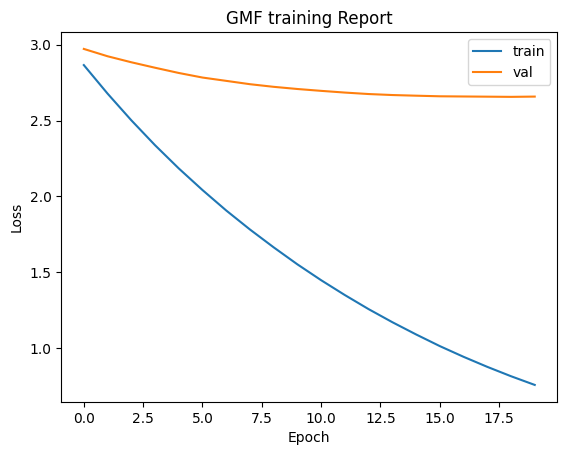

In [7]:
plt.title("GMF training Report")
plt.plot(GMF_train_report["train_loss"])
plt.plot(GMF_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#  HybMLP model

![](HybMLP_architecture.png)

In [5]:
class HybMLP(nn.Module):
    def __init__(self, num_items,num_users, items_embedding_dim,users_embedding_dim,hidden_layers_size=(50,50,50,50),dropout_prob=(0.25,0.25,0.25),output_size=1):
        super(HybMLP,self).__init__()
        self.item_embedding = nn.Embedding(num_embeddings=num_items,embedding_dim=items_embedding_dim)
        self.user_embedding = nn.Embedding(num_embeddings=num_users,embedding_dim=users_embedding_dim)
        self.hidden_layer1 = nn.Linear(in_features=items_embedding_dim+users_embedding_dim+358, out_features=hidden_layers_size[0])
        self.dropout1 = nn.Dropout(dropout_prob[0])
        self.hidden_layer2=nn.Linear(in_features=hidden_layers_size[0],out_features=hidden_layers_size[1])
        self.dropout2 = nn.Dropout(dropout_prob[1])

        self.hidden_layer3=nn.Linear(in_features=hidden_layers_size[1],out_features=hidden_layers_size[2])
        self.dropout3 = nn.Dropout(dropout_prob[2])

        self.hidden_layer4=nn.Linear(in_features=hidden_layers_size[2],out_features=hidden_layers_size[3])
        self.dropout4 = nn.Dropout(dropout_prob[3])

        self.output_layer = nn.Linear(in_features=hidden_layers_size[3],out_features=output_size)

    def forward(self,x1,x2,x3):
        item_vector=self.item_embedding(x1)
        user_vector=self.user_embedding(x2)
        concatenation=torch.cat((item_vector, user_vector, x3), dim=1)

        first_hidden=self.hidden_layer1(concatenation)
        dropout_output1=self.dropout1(first_hidden)
        relu1=F.relu(dropout_output1)

        second_hidden=self.hidden_layer2(relu1)
        dropout_output2=self.dropout2(second_hidden)
        relu2=F.relu(dropout_output2)

        third_hidden=self.hidden_layer3(relu2)
        dropout_output3=self.dropout3(third_hidden)
        relu3=F.relu(dropout_output3)

        forth_hidden=self.hidden_layer4(relu3)
        dropout_output4=self.dropout4(forth_hidden)
        relu4=F.relu(dropout_output4)

        output=self.output_layer(relu4)
        return torch.sigmoid(output)

### Initializing model

In [6]:
HybMLP_model=HybMLP(num_items=227,num_users=666536,items_embedding_dim= 20,users_embedding_dim=100,hidden_layers_size=(64,132,16,6),dropout_prob=(0.75,0.75,0.5,0.75)).to(device)
HybMLP_model.load_state_dict(torch.load("../models/HybMLP_model.pth"))
HybMLP_model.eval()

/tmp/ipykernel_6576/3498595504.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  HybMLP_model.load_state_dict(torch.load("../models/HybMLP_model.pth"))


HybMLP(
  (item_embedding): Embedding(227, 20)
  (user_embedding): Embedding(666536, 100)
  (hidden_layer1): Linear(in_features=478, out_features=64, bias=True)
  (dropout1): Dropout(p=0.75, inplace=False)
  (hidden_layer2): Linear(in_features=64, out_features=132, bias=True)
  (dropout2): Dropout(p=0.75, inplace=False)
  (hidden_layer3): Linear(in_features=132, out_features=16, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (hidden_layer4): Linear(in_features=16, out_features=6, bias=True)
  (dropout4): Dropout(p=0.75, inplace=False)
  (output_layer): Linear(in_features=6, out_features=1, bias=True)
)

### training

In [54]:
with open("../reports/HyMLP_train_report.json","r") as f:
    HybMLP_train_report = json.load(f)

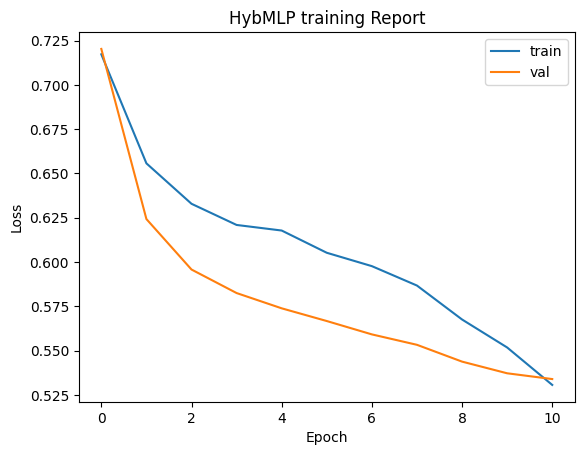

In [55]:
plt.title("HybMLP training Report")
plt.plot(HybMLP_train_report["train_loss"])
plt.plot(HybMLP_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Neural Hybrid Filtering
![](NHybF_architecture.png)

In [7]:
class NHybF(nn.Module):
    def __init__(self, num_items,num_users, items_embedding_dim,users_embedding_dim,gmf_embedding_dim,hidden_layers_size=(50,50,50,50),dropout_prob=(0.25,0.25,0.25,0.25),output_size=1):
        super(NHybF,self).__init__()
        # HybMLP architecture part
        self.item_embedding = nn.Embedding(num_embeddings=num_items,embedding_dim=items_embedding_dim)
        self.user_embedding = nn.Embedding(num_embeddings=num_users,embedding_dim=users_embedding_dim)
        self.hidden_layer1 = nn.Linear(in_features=items_embedding_dim+users_embedding_dim+358, out_features=hidden_layers_size[0])
        self.dropout1 = nn.Dropout(dropout_prob[0])
        self.hidden_layer2=nn.Linear(in_features=hidden_layers_size[0],out_features=hidden_layers_size[1])
        self.dropout2 = nn.Dropout(dropout_prob[1])

        self.hidden_layer3=nn.Linear(in_features=hidden_layers_size[1],out_features=hidden_layers_size[2])
        self.dropout3 = nn.Dropout(dropout_prob[2])

        self.hidden_layer4=nn.Linear(in_features=hidden_layers_size[2],out_features=hidden_layers_size[3])
        self.dropout4 = nn.Dropout(dropout_prob[3])

        self.HybMLP_output_layer = nn.Linear(in_features=hidden_layers_size[3],out_features=output_size)


        # GMF architecture part
        self.items_embedding1 = nn.Embedding(num_items,gmf_embedding_dim)
        self.users_embedding1 = nn.Embedding(num_users,gmf_embedding_dim)
        self.gmf_dropout = nn.Dropout(dropout_prob[4])

        self.output_layer=nn.Linear(in_features=output_size+gmf_embedding_dim,out_features=1)

    def forward(self,x1,x2,x3):
        item_vector=self.item_embedding(x1)
        user_vector=self.user_embedding(x2)
        concatenation=torch.cat((item_vector, user_vector, x3), dim=1)

        first_hidden=self.hidden_layer1(concatenation)
        dropout_output1=self.dropout1(first_hidden)
        relu1=F.relu(dropout_output1)

        second_hidden=self.hidden_layer2(relu1)
        dropout_output2=self.dropout2(second_hidden)
        relu2=F.relu(dropout_output2)

        third_hidden=self.hidden_layer3(relu2)
        dropout_output3=self.dropout3(third_hidden)
        relu3=F.relu(dropout_output3)

        forth_hidden=self.hidden_layer4(relu3)
        dropout_output4=self.dropout4(forth_hidden)
        relu4=F.relu(dropout_output4)

        HybMLP_output=self.HybMLP_output_layer(relu4)


        GMF_item_vector = self.items_embedding1(x1)
        GMF_user_vector = self.users_embedding1(x2)
        GMF_mul_vector=GMF_item_vector*GMF_user_vector
        GMF_output=self.gmf_dropout(GMF_mul_vector)

        concatenation=torch.cat((HybMLP_output, GMF_output), dim=1)

        output=self.output_layer(concatenation)

        return torch.sigmoid(output)

### Initialize model

In [8]:
NHybF_model=NHybF(num_items=227,num_users=666536,items_embedding_dim= 20,users_embedding_dim=40,gmf_embedding_dim=20,output_size=15,hidden_layers_size=(128,16,128,32),dropout_prob=(0.75,0.5,0.75,0.5,0.5)).to(device)
NHybF_model.load_state_dict(torch.load("../models/NHybF_model.pth"))
NHybF_model.eval()

/tmp/ipykernel_6576/1510918837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NHybF_model.load_state_dict(torch.load("../models/NHybF_model.pth"))


NHybF(
  (item_embedding): Embedding(227, 20)
  (user_embedding): Embedding(666536, 40)
  (hidden_layer1): Linear(in_features=418, out_features=128, bias=True)
  (dropout1): Dropout(p=0.75, inplace=False)
  (hidden_layer2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (hidden_layer3): Linear(in_features=16, out_features=128, bias=True)
  (dropout3): Dropout(p=0.75, inplace=False)
  (hidden_layer4): Linear(in_features=128, out_features=32, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (HybMLP_output_layer): Linear(in_features=32, out_features=15, bias=True)
  (items_embedding1): Embedding(227, 20)
  (users_embedding1): Embedding(666536, 20)
  (gmf_dropout): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
)

### training report

In [58]:
with open("../reports/NHybF_train_report.json","r") as f:
    NHybF_train_report = json.load(f)

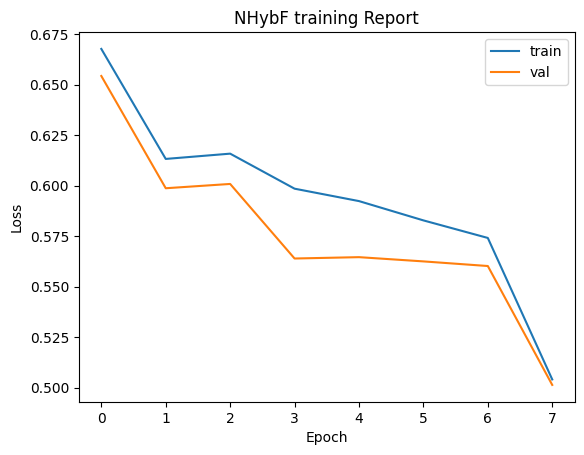

In [59]:
plt.title("NHybF training Report")
plt.plot(NHybF_train_report["train_loss"])
plt.plot(NHybF_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# ROC curve (Receiver Operating Characteristic curve)

### Reading data

In [9]:
class_0=np.load("../data/train_class_0.npy")
class1=np.load("../data/train_class_1.npy")
train=np.concatenate((class_0,class1),axis=0)
train=torch.from_numpy(train).to(torch.float32)

In [10]:
train_y=train[:,-1]

In [12]:
del train

In [24]:
class_0=np.load("../data/val_class_0.npy")
class1=np.load("../data/val_class_1.npy")
val=np.concatenate((class_0,class1),axis=0)
val=torch.from_numpy(val).to(torch.float32).to(device)

### prediction

In [26]:
with torch.no_grad():
    val_gmf_y_hat=GMF_model.to(device)(val[:,0].to(torch.int32),val[:,1].to(torch.int32))
    val_hybmlp_y_hat=HybMLP_model.to(device)(val[:,0].to(torch.int32),val[:,1].to(torch.int32),val[:,2:-1])
    val_nhypf_y_hat=NHybF_model.to(device)(val[:,0].to(torch.int32),val[:,1].to(torch.int32),val[:,2:-1])

In [11]:
with torch.no_grad():
    train_gmf_y_hat=GMF_model.cpu()(train[:,0].to(torch.int32),train[:,1].to(torch.int32))
    train_hybmlp_y_hat=HybMLP_model.cpu()(train[:,0].to(torch.int32),train[:,1].to(torch.int32),train[:,2:-1])
    train_nhypf_y_hat=NHybF_model.cpu()(train[:,0].to(torch.int32),train[:,1].to(torch.int32),train[:,2:-1])

## Roc Curve

### GMF

In [61]:
train_gmf_y_hat

tensor([0.0130, 0.0019, 0.0687,  ..., 0.0018, 0.0134, 0.9660])

In [62]:
train_y.unique()

tensor([0., 1.])

In [87]:
train_fpr,train_tpr, train_thresholds=roc_curve(train_y,train_gmf_y_hat)

In [88]:
val_fpr,val_tpr, val_thresholds=roc_curve(val[:,-1].cpu(),val_gmf_y_hat.cpu())

In [89]:
train_roc_auc = roc_auc_score(train_y,train_gmf_y_hat)
val_roc_auc = roc_auc_score(val[:,-1].cpu(),val_gmf_y_hat.cpu())

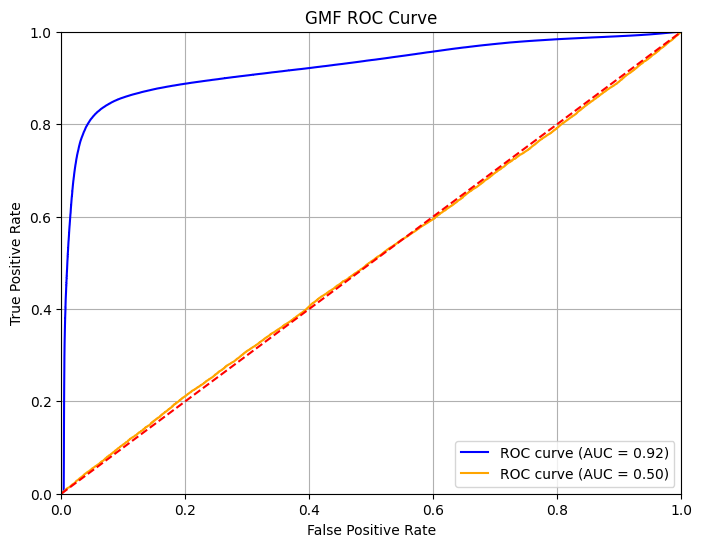

In [90]:
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(train_roc_auc))
plt.plot(val_fpr, val_tpr, color='orange', label='ROC curve (AUC = {:.2f})'.format(val_roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GMF ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [91]:
# Calculate Youden's J statistic
train_youden_j = train_tpr - train_fpr
val_youden_j = val_tpr - val_fpr
# Find the optimal threshold
train_optimal_idx = np.argmax(train_youden_j)
val_optimal_idx = np.argmax(val_youden_j)
train_optimal_threshold = train_thresholds[train_optimal_idx]
val_optimal_threshold = val_thresholds[val_optimal_idx]

print(f"Train Optimal Threshold: {train_optimal_threshold}")
print(f"Val Optimal Threshold: {val_optimal_threshold}")

Train Optimal Threshold: 0.2995157539844513
Val Optimal Threshold: 0.9920641779899597


### HybMLP

In [78]:
train_fpr,train_tpr, train_thresholds=roc_curve(train_y,train_hybmlp_y_hat)
val_fpr,val_tpr, val_thresholds=roc_curve(val[:,-1].cpu(),val_hybmlp_y_hat.cpu())

In [79]:
train_roc_auc = roc_auc_score(train_y,train_hybmlp_y_hat)
val_roc_auc = roc_auc_score(val[:,-1].cpu(),val_hybmlp_y_hat.cpu())

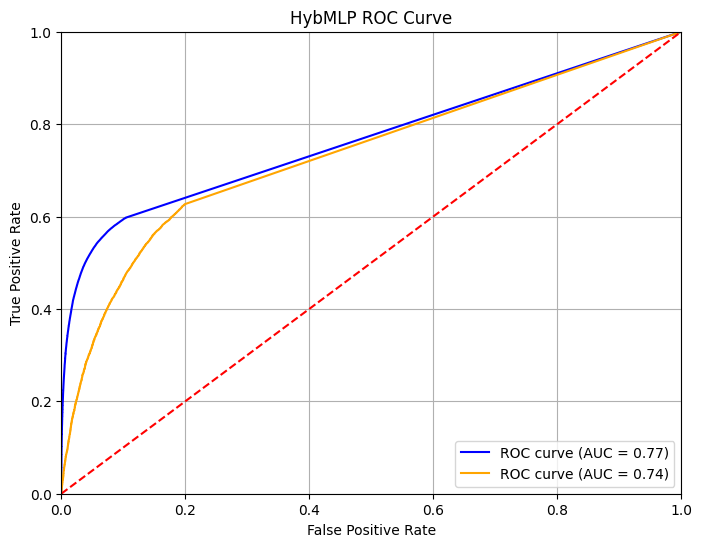

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(train_roc_auc))
plt.plot(val_fpr, val_tpr, color='orange', label='ROC curve (AUC = {:.2f})'.format(val_roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HybMLP ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [81]:
# Calculate Youden's J statistic
train_youden_j = train_tpr - train_fpr
val_youden_j = val_tpr - val_fpr
# Find the optimal threshold
train_optimal_idx = np.argmax(train_youden_j)
val_optimal_idx = np.argmax(val_youden_j)
train_optimal_threshold = train_thresholds[train_optimal_idx]
val_optimal_threshold = val_thresholds[val_optimal_idx]

print(f"Train Optimal Threshold: {train_optimal_threshold}")
print(f"Val Optimal Threshold: {val_optimal_threshold}")

Train Optimal Threshold: 0.4507424831390381
Val Optimal Threshold: 0.41450467705726624


### NHybF

In [82]:
train_fpr,train_tpr, train_thresholds=roc_curve(train_y,train_nhypf_y_hat)
val_fpr,val_tpr, val_thresholds=roc_curve(val[:,-1].cpu(),val_nhypf_y_hat.cpu())

In [83]:
train_roc_auc = roc_auc_score(train_y,train_nhypf_y_hat)
val_roc_auc = roc_auc_score(val[:,-1].cpu(),val_nhypf_y_hat.cpu())

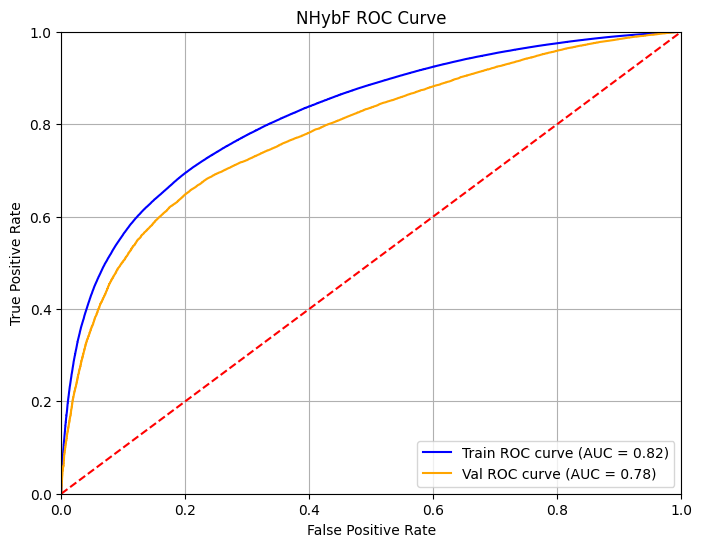

In [84]:
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', label='Train ROC curve (AUC = {:.2f})'.format(train_roc_auc))
plt.plot(val_fpr, val_tpr, color='orange', label='Val ROC curve (AUC = {:.2f})'.format(val_roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NHybF ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [85]:
# Calculate Youden's J statistic
train_youden_j = train_tpr - train_fpr
val_youden_j = val_tpr - val_fpr
# Find the optimal threshold
train_optimal_idx = np.argmax(train_youden_j)
val_optimal_idx = np.argmax(val_youden_j)
train_optimal_threshold = train_thresholds[train_optimal_idx]
val_optimal_threshold = val_thresholds[val_optimal_idx]

print(f"Train Optimal Threshold: {train_optimal_threshold}")
print(f"Val Optimal Threshold: {val_optimal_threshold}")

Train Optimal Threshold: 0.45256927609443665
Val Optimal Threshold: 0.556595504283905


# Other metrics

## HyMLP

### accuracy

In [99]:
print("train: {}".format(accuracy_score(train_y,(train_hybmlp_y_hat>0.44).to(torch.int8))))
print("val: {}".format(accuracy_score(val[:,-1].cpu(),(val_hybmlp_y_hat>0.44).cpu().to(torch.int8))))

train: 0.6492775413646364
val: 0.64545


### precision

In [100]:
print("train: {}".format(precision_score(train_y,(train_hybmlp_y_hat>0.44).to(torch.int8))))
print("val: {}".format(precision_score(val[:,-1].cpu(),(val_hybmlp_y_hat>0.44).cpu().to(torch.int8))))

train: 0.9630157481879789
val: 0.9384523342120515


### Recall

In [101]:
print("train: {}".format(recall_score(train_y,(train_hybmlp_y_hat>0.44).to(torch.int8))))
print("val: {}".format(recall_score(val[:,-1].cpu(),(val_hybmlp_y_hat>0.44).cpu().to(torch.int8))))

train: 0.5843961856194061
val: 0.609473275213094


### F1 score

In [102]:
print("train: {}".format(f1_score(train_y,(train_hybmlp_y_hat>0.44).to(torch.int8))))
print("val: {}".format(f1_score(val[:,-1].cpu(),(val_hybmlp_y_hat>0.44).cpu().to(torch.int8))))

train: 0.7273857951292317
val: 0.7390040119253561


### Confusion matrix

In [104]:
print("train: {}".format(confusion_matrix(train_y,(train_hybmlp_y_hat>0.44).to(torch.int8))))
print("val: {}".format(confusion_matrix(val[:,-1].cpu(),(val_hybmlp_y_hat>0.44).cpu().to(torch.int8))))

train: [[131493  13027]
 [241231 339204]]
val: [[14350  3292]
 [32163 50195]]


## NHybF

### accuracy

In [105]:
print("train: {}".format(accuracy_score(train_y,(train_nhypf_y_hat>0.5).to(torch.int8))))
print("val: {}".format(accuracy_score(val[:,-1].cpu(),(val_nhypf_y_hat>0.5).cpu().to(torch.int8))))

train: 0.6953604016801043
val: 0.6958


### precision

In [106]:
print("train: {}".format(precision_score(train_y,(train_nhypf_y_hat>0.5).to(torch.int8))))
print("val: {}".format(precision_score(val[:,-1].cpu(),(val_nhypf_y_hat>0.5).cpu().to(torch.int8))))

train: 0.9392307034580478
val: 0.9314790815139733


### Recall

In [107]:
print("train: {}".format(recall_score(train_y,(train_nhypf_y_hat>0.5).to(torch.int8))))
print("val: {}".format(recall_score(val[:,-1].cpu(),(val_nhypf_y_hat>0.5).cpu().to(torch.int8))))

train: 0.6623652949942715
val: 0.6807110420359892


### F1 score

In [109]:
print("train: {}".format(f1_score(train_y,(train_nhypf_y_hat>0.5).to(torch.int8))))
print("val: {}".format(f1_score(val[:,-1].cpu(),(val_nhypf_y_hat>0.5).cpu().to(torch.int8))))

train: 0.776867353021409
val: 0.7865922101245931


### confuse martix

In [110]:
print("train: {}".format(confusion_matrix(train_y,(train_nhypf_y_hat>0.5).to(torch.int8))))
print("val: {}".format(confusion_matrix(val[:,-1].cpu(),(val_nhypf_y_hat>0.5).cpu().to(torch.int8))))

train: [[119645  24875]
 [195975 384460]]
val: [[13518  4124]
 [26296 56062]]


# observations:
- GMF model's performance is extremely poor
- Precision score of NHybF model is lower than HyMLP model, it means NHybF more likely to call a negative instance as positive.
- NHybF computationally expensive compare to HyMLP
- Overall, HyMLP is best model among three.
- 

# Performance On Test Dataset

In [111]:
class_0=np.load("../data/test_class_0.npy")
class1=np.load("../data/test_class_1.npy")
test=np.concatenate((class_0,class1),axis=0)

In [112]:
test=torch.from_numpy(test).to(torch.float32).to(device)

In [115]:
with torch.no_grad():
    HyMLP_y_hat=HybMLP_model(test[:,0].to(torch.int32),test[:,1].to(torch.int32),test[:,2:-1])

### Accuracy

In [117]:
accuracy_score(test[:,-1].cpu(),HyMLP_y_hat.cpu()>0.44)

0.6433

### precision score

In [118]:
precision_score(test[:,-1].cpu(),HyMLP_y_hat.cpu()>0.44)

0.9388992886559341

### recall score

In [119]:
precision_score(test[:,-1].cpu(),HyMLP_y_hat.cpu()>0.44)

0.9388992886559341

### f1 score

In [120]:
f1_score(test[:,-1].cpu(),HyMLP_y_hat.cpu()>0.44)

0.7376858701887015

### confuse matrix

In [122]:
confusion_matrix(test[:,-1].cpu(),HyMLP_y_hat.cpu()>0.44)

array([[14174,  3264],
       [32406, 50156]])